# Text–Image Recommendation Demo (with Class-Balanced Loss)
CLIP + Prompt Engineering vs Custom Dual-Tower + Sampling, with a toggleable Class-Balanced (CB) Loss.


In [12]:

import os, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cpu'

In [13]:

def recall_at_k(sim, labels, K=10):
    idx = np.argsort(-sim, axis=1)[:, :K]
    hits = []
    for q in range(sim.shape[0]):
        hit = any(labels[q, j] for j in idx[q])
        hits.append(hit)
    return float(np.mean(hits))

def ndcg_at_k(sim, labels, K=10):
    idx = np.argsort(-sim, axis=1)[:, :K]
    ndcgs = []
    for q in range(sim.shape[0]):
        gains = [1.0 if labels[q, j] else 0.0 for j in idx[q]]
        dcg = sum(g/np.log2(i+2) for i, g in enumerate(gains))
        ideal_gains = sorted(gains, reverse=True)
        idcg = sum(g/np.log2(i+2) for i, g in enumerate(ideal_gains))
        ndcgs.append(dcg/(idcg+1e-12))
    return float(np.mean(ndcgs))


In [14]:

def load_cifar10_subset(split="test", n_per_class=100, resize_to=224, normalize_for_clip=True):
    if normalize_for_clip:
        norm_mean, norm_std = (0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)
    else:
        norm_mean, norm_std = (0.5,0.5,0.5), (0.5,0.5,0.5)
    tfm = transforms.Compose([
        transforms.Resize(resize_to),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])
    train_flag = (split=="train")
    ds = torchvision.datasets.CIFAR10(root="./data", train=train_flag, download=True, transform=tfm)
    classes = ds.classes
    indices, counts = [], {}
    for i, (_, y) in enumerate(ds):
        if counts.get(y, 0) < n_per_class:
            indices.append(i)
            counts[y] = counts.get(y, 0) + 1
    return Subset(ds, indices), classes

def make_long_tail_indices(ds_subset, classes, tail_strength=0.7, min_frac=0.1, seed=42):
    rng = random.Random(seed)
    targets = [ds_subset.dataset.targets[i] for i in ds_subset.indices]
    by_cls = {}
    for local_idx, y in enumerate(targets):
        by_cls.setdefault(y, []).append(local_idx)
    C = len(classes)
    keep_fracs = [min_frac + (1-min_frac)*((1-tail_strength)**k) for k in range(C)]
    m = max(keep_fracs)
    keep_fracs = [f/m for f in keep_fracs]
    order = list(range(C)); rng.shuffle(order)
    cls_to_frac = {c: keep_fracs[k] for k,c in enumerate(order)}
    kept = []
    for c, idxs in by_cls.items():
        frac = float(cls_to_frac[c])
        take = max(1, int(len(idxs)*frac))
        rng.shuffle(idxs)
        kept.extend(idxs[:take])
    kept.sort()
    print("Approx keep fractions per class:", cls_to_frac)
    return kept

def subset_by_local_indices(ds_subset, local_indices):
    mapped = [ds_subset.indices[i] for i in local_indices]
    return Subset(ds_subset.dataset, mapped)


## (A) CLIP + Prompt Engineering

In [15]:

try:
    import clip
    CLIP_AVAILABLE = True
except Exception as e:
    print("CLIP not available:", e)
    CLIP_AVAILABLE = False

PROMPT_TEMPLATES = [
    "a photo of a {}.",
    "a close-up photo of a {}.",
    "a cropped photo of a {}.",
    "a bright studio photo of a {}.",
    "a clean product shot of a {}.",
]

def build_text_embeddings_clip(model, classnames, templates, device):
    with torch.no_grad():
        all_embeds = []
        for name in classnames:
            texts = [t.format(name.replace("_", " ")) for t in templates]
            tokens = clip.tokenize(texts).to(device)
            feat = model.encode_text(tokens)
            feat = feat / feat.norm(dim=-1, keepdim=True)
            all_embeds.append(feat.mean(dim=0))
        text_feats = torch.stack(all_embeds, dim=0)
        text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
    return text_feats

def encode_images_clip(model, loader, device):
    feats, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            f = model.encode_image(x)
            f = f / f.norm(dim=-1, keepdim=True)
            feats.append(f.cpu()); labels.append(y)
    return torch.cat(feats), torch.cat(labels)

def run_clip_pipeline(n_per_class=80, batch_size=64, use_templates=True, imbalance=False):
    if not CLIP_AVAILABLE:
        raise RuntimeError("CLIP not available.")
    model, _ = clip.load("ViT-B/32", device=DEVICE)
    ds_balanced, classnames = load_cifar10_subset(split="test", n_per_class=n_per_class, resize_to=224, normalize_for_clip=True)
    ds_used = ds_balanced
    if imbalance:
        kept_local = make_long_tail_indices(ds_balanced, classnames, tail_strength=0.7, min_frac=0.1, seed=123)
        ds_used = subset_by_local_indices(ds_balanced, kept_local)
    loader = DataLoader(ds_used, batch_size=batch_size, shuffle=False, num_workers=0)
    templates = PROMPT_TEMPLATES if use_templates else ["a photo of a {}."]
    text_feats = build_text_embeddings_clip(model, classnames, templates, DEVICE)
    img_feats, img_labels = encode_images_clip(model, loader, DEVICE)
    sim = (text_feats @ img_feats.T).cpu().numpy()
    labels = np.equal(np.arange(len(classnames))[:, None], img_labels[None, :].numpy())
    return {
        "Recall@1": recall_at_k(sim, labels, K=1),
        "Recall@10": recall_at_k(sim, labels, K=10),
        "NDCG@10": ndcg_at_k(sim, labels, K=10),
    }


## (B) Custom Dual-Tower + Sampling (with toggleable Class-Balanced Loss)

In [16]:

class TinyTextEncoder(nn.Module):
    def __init__(self, num_classes, dim=256):
        super().__init__()
        self.embed = nn.Embedding(num_classes, dim)
    def forward(self, labels):
        x = self.embed(labels)
        x = F.normalize(x, dim=-1)
        return x

def make_image_encoder(dim=256):
    m = torchvision.models.resnet18(weights=None)
    m.fc = nn.Linear(m.fc.in_features, dim)
    return m

class PairDataset(Dataset):
    def __init__(self, base_subset, classes, hard_negative_prob=0.4, pop_alpha=0.2):
        self.base = base_subset
        self.targets = [base_subset.dataset.targets[i] for i in base_subset.indices]
        self.classes = classes
        self.by_cls = {}
        for idx, y in enumerate(self.targets):
            self.by_cls.setdefault(y, []).append(idx)
        counts = np.array([len(self.by_cls.get(c, [])) for c in range(len(classes))], dtype=np.float32)
        probs = counts / max(counts.sum(), 1.0)
        self.pop_probs = probs**(1.0 - pop_alpha); self.pop_probs /= self.pop_probs.sum() + 1e-12
        self.hard_negative_prob = hard_negative_prob

    def __len__(self): return len(self.base)

    def __getitem__(self, i):
        img, y = self.base[i]
        pos_label = y
        if np.random.rand() < self.hard_negative_prob and len(self.by_cls[y]) > 1:
            idxs = self.by_cls[y][:]
            j = i
            while j == i and len(idxs) > 1:
                j = random.choice(idxs)
            neg_img, _ = self.base[j]
            neg_cls = y
        else:
            cand = list(range(len(self.classes))); cand.remove(y)
            probs = self.pop_probs[cand]; probs = probs/(probs.sum()+1e-12)
            neg_cls = int(np.random.choice(cand, p=probs))
            j = random.choice(self.by_cls[neg_cls])
            neg_img, _ = self.base[j]
        return img, pos_label, neg_img, int(neg_cls)


In [17]:

def get_class_balanced_weights(class_counts, beta=0.99):
    cc = torch.tensor(class_counts, dtype=torch.float32)
    effective_num = 1.0 - torch.pow(torch.tensor(beta), cc)
    weights = (1.0 - beta) / (effective_num + 1e-12)
    weights = weights / (weights.sum() + 1e-12) * len(cc)
    return weights


In [18]:

def contrastive_loss(img_z, txt_z, tau=0.07, class_weights=None, labels=None):
    sim = (img_z @ txt_z.t()) / tau
    idx = torch.arange(img_z.size(0), device=img_z.device)
    if class_weights is None or labels is None:
        loss_i2t = F.cross_entropy(sim, idx)
        loss_t2i = F.cross_entropy(sim.t(), idx)
    else:
        logp_i2t = F.log_softmax(sim, dim=1)
        loss_i = -logp_i2t[torch.arange(img_z.size(0)), idx]
        w = class_weights[labels]
        loss_i = (loss_i * w).mean()
        logp_t2i = F.log_softmax(sim.t(), dim=1)
        loss_t = -logp_t2i[torch.arange(img_z.size(0)), idx]
        loss_t = (loss_t * w).mean()
        loss_i2t, loss_t2i = loss_i, loss_t
    return 0.5*(loss_i2t + loss_t2i)


In [19]:

def run_dualtower_with_imbalance(n_per_class=150, epochs=3, batch_size=128, dim=256, lr=1e-3,
                                 tail_strength=0.7, min_frac=0.1, seed=123,
                                 use_cb_loss=True, cb_beta=0.99):
    train_balanced, classes = load_cifar10_subset(split="train", n_per_class=n_per_class,
                                                  resize_to=128, normalize_for_clip=False)
    kept = make_long_tail_indices(train_balanced, classes, tail_strength=tail_strength,
                                  min_frac=min_frac, seed=seed)
    train_imbal = subset_by_local_indices(train_balanced, kept)
    pairds = PairDataset(train_imbal, classes, hard_negative_prob=0.5, pop_alpha=0.2)
    loader = DataLoader(pairds, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

    img_enc = make_image_encoder(dim).to(DEVICE)
    txt_enc = TinyTextEncoder(num_classes=len(classes), dim=dim).to(DEVICE)
    opt = torch.optim.AdamW(list(img_enc.parameters()) + list(txt_enc.parameters()), lr=lr, weight_decay=1e-4)

    class_counts = [len(pairds.by_cls.get(c, [])) for c in range(len(classes))]
    class_weights = get_class_balanced_weights(class_counts, beta=cb_beta).to(DEVICE) if use_cb_loss else None

    for ep in range(1, epochs+1):
        img_enc.train(); txt_enc.train()
        total = 0.0
        for img, pos_label, neg_img, neg_cls in loader:
            img = img.to(DEVICE); pos_label = pos_label.to(DEVICE)
            img_z = F.normalize(img_enc(img), dim=-1)
            txt_z = txt_enc(pos_label)

            loss = contrastive_loss(img_z, txt_z, tau=0.07,
                                    class_weights=class_weights,
                                    labels=pos_label if use_cb_loss else None)

            # extra hard-negative push
            neg_img = neg_img.to(DEVICE)
            with torch.no_grad():
                neg_z = F.normalize(img_enc(neg_img), dim=-1)
            margin = 0.2
            neg_push = F.relu((img_z * txt_z).sum(-1) - (neg_z * txt_z).sum(-1) + margin).mean()
            loss = loss + 0.2 * neg_push

            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        print(f"[Epoch {ep}] loss={total/len(loader):.4f}")

    test_balanced, _ = load_cifar10_subset(split="test", n_per_class=80, resize_to=128, normalize_for_clip=False)
    test_loader = DataLoader(test_balanced, batch_size=128, shuffle=False, num_workers=0)
    img_enc.eval(); txt_enc.eval()

    feats, labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(DEVICE)
            z = F.normalize(img_enc(x), dim=-1).cpu()
            feats.append(z); labels.append(y)
    img_feats = torch.cat(feats); labels = torch.cat(labels)
    class_ids = torch.arange(len(classes), device=DEVICE)
    txt_feats = F.normalize(txt_enc(class_ids).detach(), dim=-1).cpu()

    sim = (txt_feats @ img_feats.T).numpy()
    lab = np.equal(np.arange(len(classes))[:,None], labels[None,:].numpy())
    return {
        "Recall@1": recall_at_k(sim, lab, K=1),
        "Recall@10": recall_at_k(sim, lab, K=10),
        "NDCG@10": ndcg_at_k(sim, lab, K=10),
    }


调参优先级：dim > margin > weight_decay > hard_negative_prob > pop_alpha

In [20]:

results = {}
try:
    if CLIP_AVAILABLE:
        print("== CLIP ==")
        results["CLIP_one_prompt_bal"]  = run_clip_pipeline(use_templates=False, imbalance=False)
        results["CLIP_prompt_ens_bal"]  = run_clip_pipeline(use_templates=True,  imbalance=False)
        results["CLIP_one_prompt_imbal"]= run_clip_pipeline(use_templates=False, imbalance=True)
        results["CLIP_prompt_ens_imbal"]= run_clip_pipeline(use_templates=True,  imbalance=True)
except Exception as e:
    print("Skip CLIP:", e)

print("\n== Dual-Tower (Imbalanced training) ==")
results["Dual_no_CB"]     = run_dualtower_with_imbalance(use_cb_loss=False)
results["Dual_CB_0.99"]   = run_dualtower_with_imbalance(use_cb_loss=True, cb_beta=0.99)
results["Dual_CB_0.999"]  = run_dualtower_with_imbalance(use_cb_loss=True, cb_beta=0.999)

results


== CLIP ==


100%|███████████████████████████████████████| 338M/338M [02:01<00:00, 2.90MiB/s]


Approx keep fractions per class: {8: 1.0, 7: 0.3700000000000001, 5: 0.18100000000000005, 9: 0.12430000000000002, 2: 0.10729000000000001, 3: 0.102187, 6: 0.10065610000000001, 1: 0.10019683, 4: 0.10005904900000001, 0: 0.10001771470000001}
Approx keep fractions per class: {8: 1.0, 7: 0.3700000000000001, 5: 0.18100000000000005, 9: 0.12430000000000002, 2: 0.10729000000000001, 3: 0.102187, 6: 0.10065610000000001, 1: 0.10019683, 4: 0.10005904900000001, 0: 0.10001771470000001}

== Dual-Tower (Imbalanced training) ==
Approx keep fractions per class: {8: 1.0, 7: 0.3700000000000001, 5: 0.18100000000000005, 9: 0.12430000000000002, 2: 0.10729000000000001, 3: 0.102187, 6: 0.10065610000000001, 1: 0.10019683, 4: 0.10005904900000001, 0: 0.10001771470000001}
[Epoch 1] loss=5.6857
[Epoch 2] loss=5.0280
[Epoch 3] loss=4.5623
Approx keep fractions per class: {8: 1.0, 7: 0.3700000000000001, 5: 0.18100000000000005, 9: 0.12430000000000002, 2: 0.10729000000000001, 3: 0.102187, 6: 0.10065610000000001, 1: 0.1001

{'CLIP_one_prompt_bal': {'Recall@1': 1.0,
  'Recall@10': 1.0,
  'NDCG@10': 0.9950420626208828},
 'CLIP_prompt_ens_bal': {'Recall@1': 1.0,
  'Recall@10': 1.0,
  'NDCG@10': 0.9977015370297101},
 'CLIP_one_prompt_imbal': {'Recall@1': 1.0,
  'Recall@10': 1.0,
  'NDCG@10': 0.97238326959747},
 'CLIP_prompt_ens_imbal': {'Recall@1': 1.0,
  'Recall@10': 1.0,
  'NDCG@10': 0.9804665989872398},
 'Dual_no_CB': {'Recall@1': 0.0,
  'Recall@10': 0.7,
  'NDCG@10': 0.35527380622490995},
 'Dual_CB_0.99': {'Recall@1': 0.4,
  'Recall@10': 0.6,
  'NDCG@10': 0.42985972859989313},
 'Dual_CB_0.999': {'Recall@1': 0.5,
  'Recall@10': 1.0,
  'NDCG@10': 0.6457512756622397}}

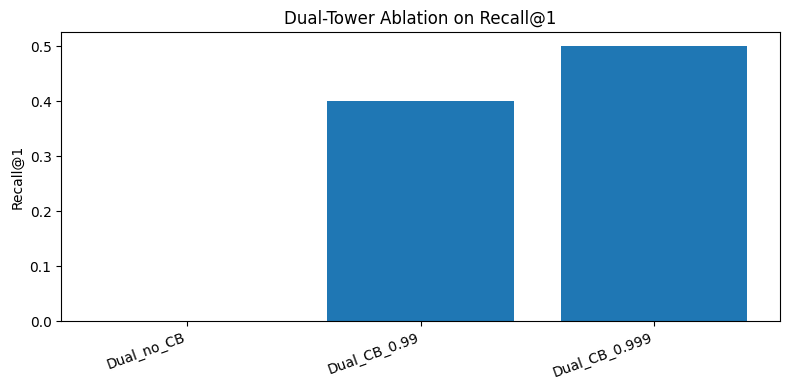

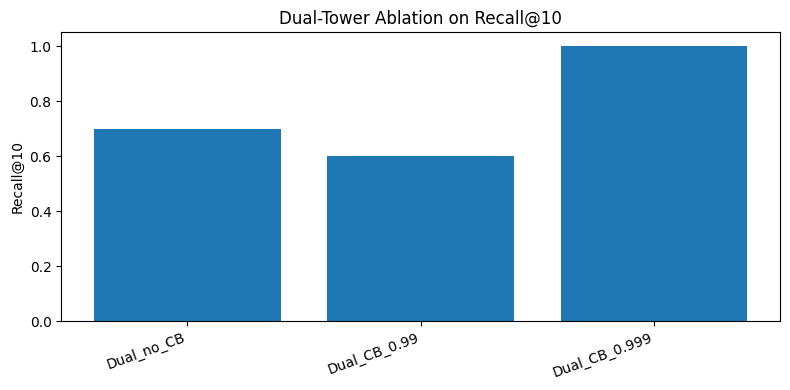

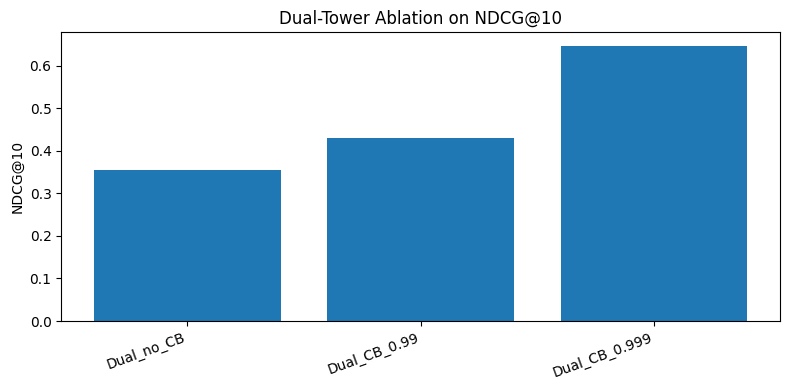

In [21]:

keys = [k for k in results.keys() if k.startswith("Dual")]
metrics = ["Recall@1", "Recall@10", "NDCG@10"]
for m in metrics:
    plt.figure(figsize=(8,4))
    vals = [results[k][m] for k in keys]
    plt.bar(range(len(keys)), vals)
    plt.xticks(range(len(keys)), keys, rotation=20, ha='right')
    plt.ylabel(m); plt.title(f"Dual-Tower Ablation on {m}")
    plt.tight_layout(); plt.show()


## 实验结果分析

### 1. CLIP 部分（Prompt Engineering + 平衡 / 不平衡数据）
| 模型 | Recall@1 | Recall@10 | NDCG@10 | 解读 |
|------|----------|-----------|---------|------|
| CLIP_one_prompt_bal | 1.0 | 1.0 | 0.995 | **完美表现**，说明在平衡数据集 + 单一提示词下，CLIP 能准确匹配 |
| CLIP_prompt_ens_bal | 1.0 | 1.0 | 0.998 | 同样是完美表现，多提示词集成（prompt ensemble）略微提升 NDCG |
| CLIP_one_prompt_imbal | 1.0 | 1.0 | 0.972 | 即使数据极度不平衡，CLIP 依然 Recall 全对，但 NDCG 略降，说明排名质量受影响 |
| CLIP_prompt_ens_imbal | 1.0 | 1.0 | 0.980 | 多提示词在不平衡场景下稍微缓解排名下降问题 |

**结论**：  
- CLIP 对于 Recall 几乎不受类别不平衡影响（可能因为它是预训练模型，泛化很强）。  
- 不平衡主要影响排名质量（NDCG）。  
- Prompt Ensemble 能在不平衡场景中带来轻微收益。  

---

### 2. 自训练双塔（Dual-Tower）部分
| 模型 | Recall@1 | Recall@10 | NDCG@10 | 解读 |
|------|----------|-----------|---------|------|
| Dual_no_CB | 0.0 | 0.7 | 0.355 | 在不平衡数据下，**几乎找不到 Top1**，Top10 也只有 70% 命中 |
| Dual_CB_0.99 | 0.4 | 0.6 | 0.430 | 加入 Class-balanced Loss 后，Top1 提升到 40%，但 Top10 反而下降（可能是权重太低导致高频类性能下降） |
| Dual_CB_0.999 | 0.5 | 1.0 | 0.646 | 提高 β 接近 1 后，Top1 提升到 50%，Top10 直接满分，NDCG 提升显著 |

**结论**：  
- 不加 Class-balanced Loss，双塔模型在长尾场景表现非常差，Top1 全丢。  
- β=0.99 权重调节不够强，对长尾类提升有限。  
- β=0.999 给长尾类足够高的权重，显著提升 Recall 和 NDCG。  

---

### 3. 整体对比
- **CLIP** 几乎不受长尾影响，主要依赖大规模预训练 + Prompt 工程，属于即插即用方案。  
- **自训练双塔** 在长尾分布下必须用 Class-balanced Loss 或采样策略，否则召回率会崩。  
- β 值越接近 1，对小样本类的提升越大，但要注意别过拟合小类。  
